In [1]:
import pandas as pd
from sklearn.metrics import classification_report

# Validation set

In [25]:
df_test = pd.read_csv('../../NCYPred/dataset/validation-set-rfam-corrected.csv', index_col=0)

In [26]:
for n,s in enumerate(df_test.label):
    if s == 'sbRNA':
        df_test['labels'][n] = 'Y-RNA'

In [4]:
df_test

,index,id,seq,label
0,21355,LGCL01000045.1/11910-11982,AATTAAAAAAGCGATGAGGCTCGCTTGAGATGTAATCAAACCGCCG...,Riboswitch
1,11684,ALWZ044445528.1/962-1083,ATCCTAGGTAAGCCCTTTAAACTACTTATCTGATTTATGGGAGACA...,HACA-box
2,14551,LT598460.1/687408-687646,AACTTTGTCCAAAAGTACTCCACCGCAATAGACAGTACGACGGCCG...,HACA-box
3,6725,AYZS02015661.1/13237-13329,TTGCCATGATGATTTCAAATTATTAGGAAAGCATTATGCTAATGCT...,CD-box
4,28222,KB846811.1/2403452-2403262,AATCTGGGAAGAGAGCTTCCTTCAGTCCACTCATGGGGAGTGGTAA...,miRNA
...,...,...,...,...
13641,18742,FCNA01000158.1/16563-16326,GAAAAAGCGTTGAAAAGATGAGTAGTTTTGGATAGACTTATAGAGA...,Leader
13642,13516,AFYH01058929.1/8670-8538,TCCCAAGGTGTTGAGTTCAGTTCAGGGCTGCTTCCCTGTTCTGGTA...,HACA-box
13643,28677,ABEG02003677.1/12241-12145,AAGGGGTGTCAAAGTAGAGGTAGGTGCGAGAAATGACGGGCATCGT...,miRNA
13644,6156,CM002815.1/56721418-56721311,CGTCATGATTTGGGCATTGCATTAACTTATCATTAAAGTATGTTGA...,CD-box


## Generate tokens

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

In [6]:
def remove(df):
	for i in range(len(df.seq)):
		for j in ['N', 'Y', 'K', 'W', 'R', 'H', 'M', 'S', 'D', 'V', 'B']:
			if j in df.seq[i]:
				df = df.drop(index=i)
				break

	df = df.reset_index(drop=True)
	return df

def seq_to_3mer(seq_list):
	print('Processing {} sequences'.format(len(seq_list)))
	
	main_list = []
	
	for _, i in enumerate(seq_list):
		# print('type(i): ', type(i))
		# print('type([i]): ', type([i]))
		# print('type(list(i)): ', type(list(i)))
		seq = list(i)
		seq_kmer = []

		for j, _ in enumerate(seq):
			if j < len(seq) - 2:
				seq_kmer.append(seq[j] + seq[j+1] + seq[j+2])
			else:
				continue

		main_list.append(seq_kmer)

	return main_list 

def token_pad(sentences, max_len, prefix):
	print('Zero-padding sequences to {} and tokenizing'.format(max_len))

	with open('./tokenizer.pickle', 'rb') as handle:
		tokenizer = pickle.load(handle)

	tokens = tokenizer.texts_to_sequences(sentences)
	all_pad = pad_sequences(tokens, max_len, padding=prefix)

	return all_pad

def argmax_to_label(predictions):
	label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I',
		'Intron-gp-II', 'Leader', 'Riboswitch', 'Ribozyme', 'Y-RNA',
		'Y-RNA-like', 'miRNA', 'tRNA']

	argmax_pred = np.argmax(predictions, axis=1)
	argmax_values = range(13)
	pred_labels = []

	for p in argmax_pred:
		for n, l in zip(argmax_values, label_list):
			if p == n:
				pred_labels.append(l)

	return np.array(pred_labels, dtype='object'), label_list

In [7]:
# Remove ambiguous nucleotides
df_test = remove(df_test)

# Generate k-mers
X_3mer_test = seq_to_3mer(df_test['seq'])

Processing 13646 sequences


In [8]:
# Tokenization and zero-padding
X_test = token_pad(X_3mer_test, 498, 'post')

Zero-padding sequences to 498 and tokenizing


In [9]:
y_test = np.ravel(df_test['label'])

In [10]:
print(X_test.shape, y_test.shape)

(13646, 498) (13646,)


## Neural networks

In [11]:
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.6.0


In [12]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

def predict(model_name, X):
    
    model = keras.models.load_model('./{}/'.format(model_name))
    y_pred_prob = model.predict(X)
    y_pred, label_list = argmax_to_label(y_pred_prob)
    
    return y_pred_prob, y_pred

def get_metrics(y_test, y_pred, y_pred_prob, model_name):
    
    # encoding das classes
    y_test_encode = np.argmax(pd.get_dummies(y_test).values, axis=1)
    y_pred_encode = np.argmax(pd.get_dummies(y_pred).values, axis=1)
    
    print(model_name)
    print('accuracy: {}'.format(balanced_accuracy_score(y_test_encode, y_pred_encode)))
    print('precision: {}'.format(precision_score(y_test_encode, y_pred_encode, average='weighted')))
    print('recall: {}'.format(recall_score(y_test_encode, y_pred_encode, average='weighted')))
    print('f1_score: {}'.format(f1_score(y_test_encode, y_pred_encode, average='weighted')))
    print('MCC: {}'.format(matthews_corrcoef(y_test_encode, y_pred_encode)))
    print('ROC AUC: {}'.format(roc_auc_score(y_test_encode, y_pred_prob, average='macro', multi_class='ovo')))
    
    title = 'Validation set'
    plot_cm(y_test_encode, y_pred_encode, 'true','.2f', title)
    plot_cm(y_test_encode, y_pred_encode, None,'.0f', title)

In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
							 confusion_matrix,
							 roc_auc_score)

label_list = ['5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I', 
              'Intron-gp-II', 'Leader', 'Riboswitch', 'Ribozyme', 'Y-RNA',
              'Y-RNA-like', 'miRNA ', 'tRNA']


def plot_cm(labels, argmax_prediction, normalize, fmt, title):
    cm = confusion_matrix(labels, argmax_prediction, normalize=normalize)
    fig = plt.figure(figsize=(10, 8), dpi=150)
    sns.set(font_scale=1.3)
    sns.heatmap(cm, xticklabels=label_list, yticklabels=label_list,
                cmap='Reds', fmt=fmt, square=True, annot=True)
    
    plt.title(title, fontsize=20)
    plt.ylabel("True label", fontsize=19)
    plt.xlabel("Predicted label", fontsize=19)
    #ax = fig.add_subplot(111)
    #plt.set_xticklabels(label_list)
    #plt.set_yticklabels(label_list)
    plt.yticks(rotation='horizontal', fontsize=18)
    plt.xticks(rotation='vertical', fontsize=18)
    plt.show()

NCYPred
accuracy: 0.8950870736862435
precision: 0.9169886797320965
recall: 0.9155796570423568
f1_score: 0.9158939818083853
MCC: 0.9059970053892809
ROC AUC: 0.9945472944988385


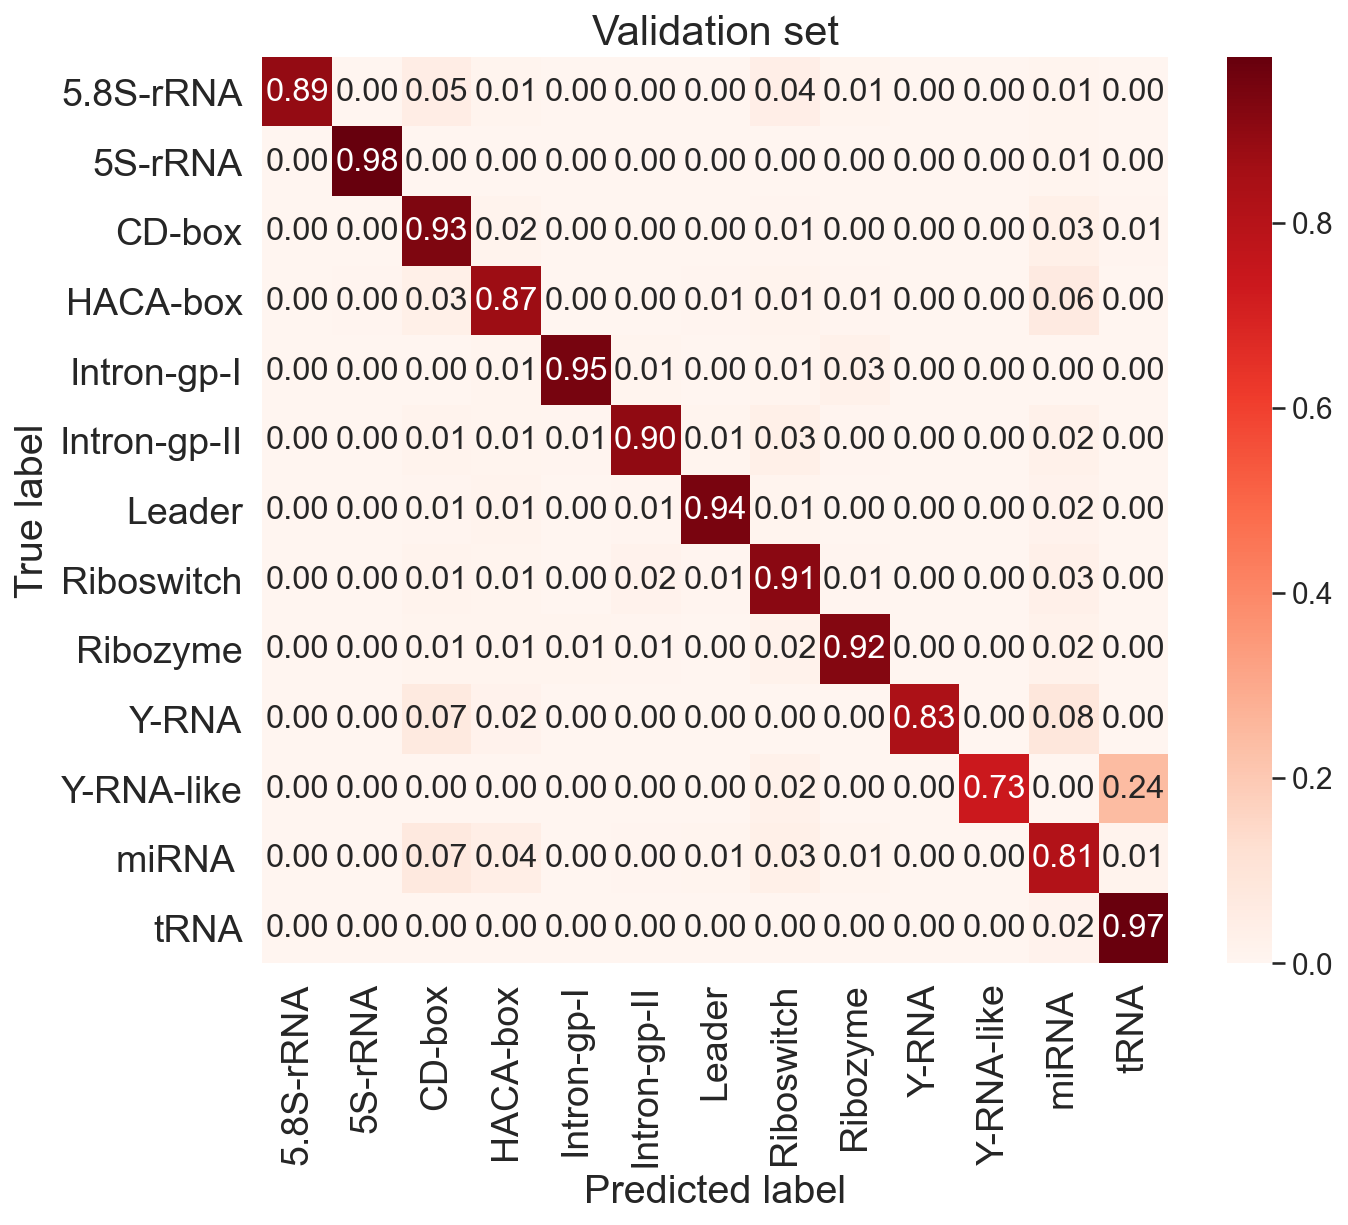

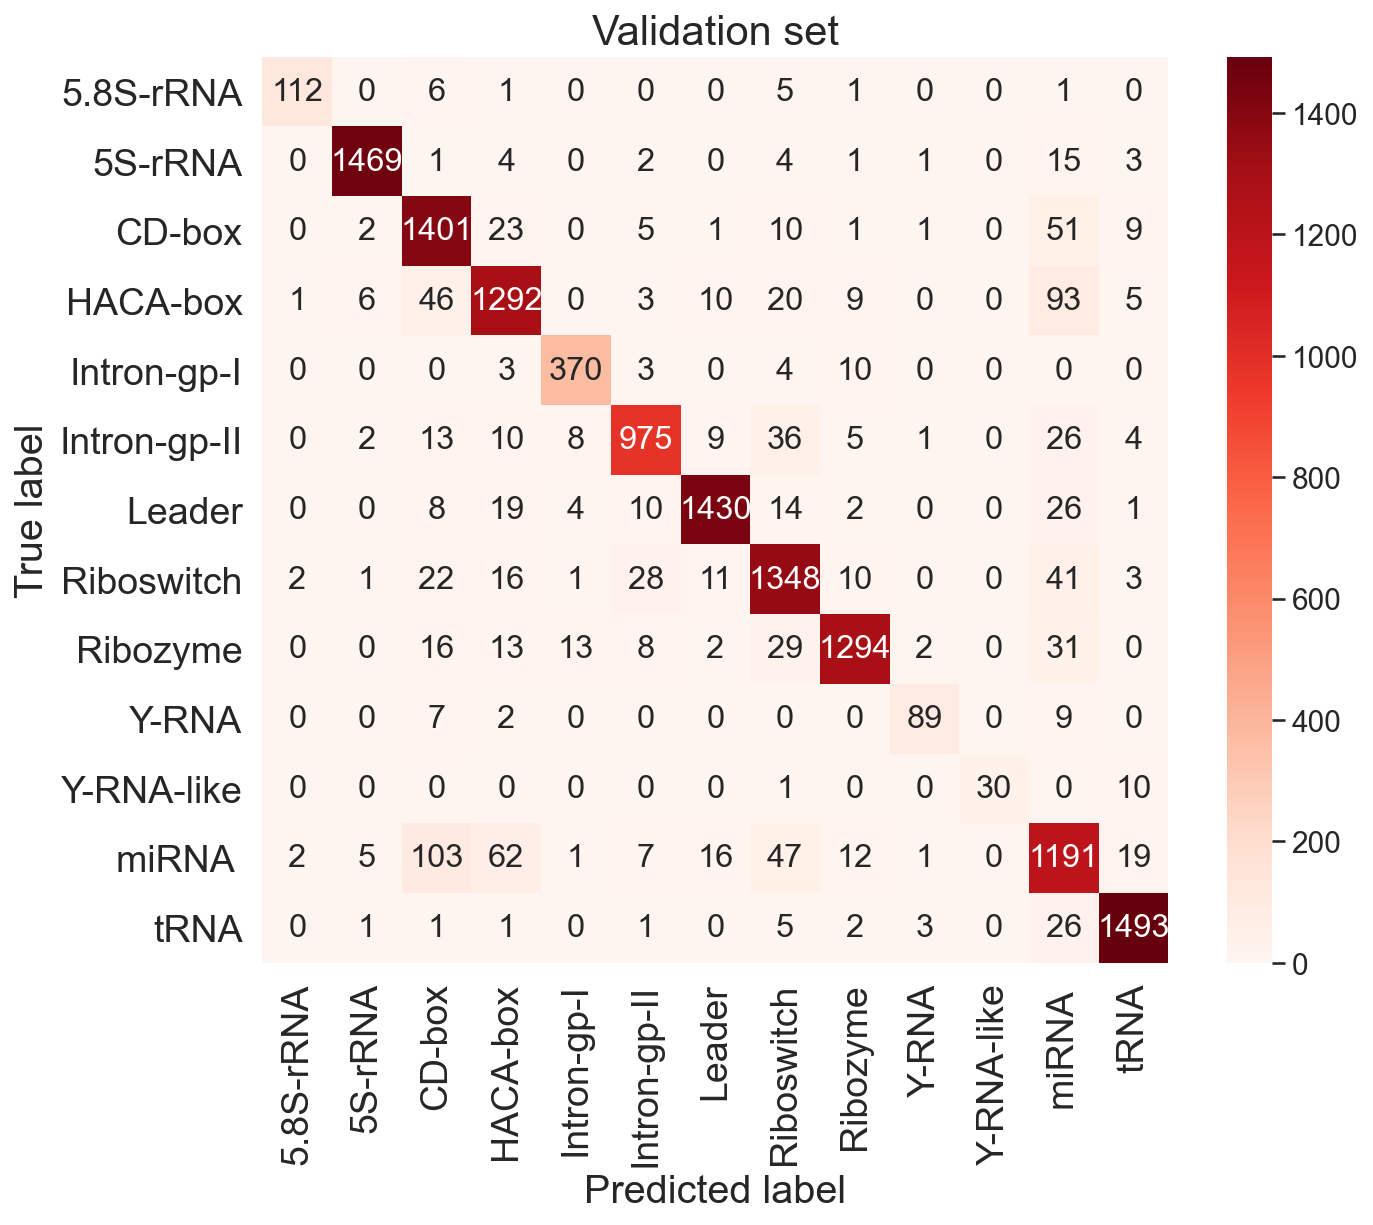

In [24]:
# NCYPred
y_pred_prob, y_pred = predict('NCYPred_model', X_test)
get_metrics(y_test, y_pred, y_pred_prob, 'NCYPred')

# Attention weights

In [14]:
import tensorflow as tf

def Predict(model, X):
    
    """ Classify a sequence of tokens and output the attention distribution """
    
    # input: model, data, attention layer index, output distrbution from attention layer
    
    predictions = tf.keras.Model(inputs = model.input, 
                                 outputs = [model.output,
                                            model.layers[3].output[0],
                                            model.layers[3].output[1]])
    
    output, context, weights = predictions.predict(X)
    #weights = tf.squeeze(weights, 1)
    #context = tf.squeeze(context, 1)
    
    # return as dataframe
    new_df = pd.DataFrame()
    new_df['prediction'] = np.argmax(output, axis=1)
    new_df['c_vector'] = list(context)
    new_df['weights'] = list(weights)
    
    return new_df

In [15]:
model = keras.models.load_model('./NCYPred_model/')

In [17]:
df_test = df_test.sort_values('label')
df_test = df_test.reset_index(drop=True)

In [33]:
df_test = df_test.groupby('label').apply(lambda x: x.sample(25)).reset_index(drop=True)

In [34]:
df_test

,index,id,seq,label
0,35852,CM001582.2/59292719-59292558,AACTCTTAGTGGTGGATCACTTGGCTTGCGCATCAGTGAAGAATGC...,5.8S-rRNA
1,35978,AFEW01015203.1/290-122,GACTCTTGACAATAGATATCTCGCCTCTCGCATTGATGAAGAACGC...,5.8S-rRNA
2,35574,AWHE01031026.1/19813-19661,AAATTTGCCTATACTCTTGGCTCCTGTCACCATGAAGAACATGGTA...,5.8S-rRNA
3,35647,JRRC01441731.1/4412-4260,AACCCCGAACGGTGGATCACTCGGCTCGCGGATCGATGAAGACCGC...,5.8S-rRNA
4,35783,APLE01004887.1/232951-233104,GACTCTCGGCAAACGATATCTCCACTCTCTCATTGACGAAGAACGT...,5.8S-rRNA
...,...,...,...,...
320,32958,CM001232.1/2632921-2632783,GGTCAGATGGCCGAGCGGTCTAAGGCGCTAGCTTCAGGTTGATATC...,tRNA
321,31802,MFWN01000039.1/5424-5290,CCCATCATAGCTCAGTGGTAGAGCGTTCGGCTGTAGCATTTATGCT...,tRNA
322,30854,HG970335.2/4769227-4769127,GCGTAATTGGTTTAGTGGTAAAATTCTCCGTTGCCATCCGGGTTTC...,tRNA
323,32863,CP001605.1/176319-176235,ACCTGGATGACGAAAATGGTAAACGTACTGAACTCAAAATTCAGGG...,tRNA


In [35]:
# Remover caracteres proibidos
df_test = remove(df_test)

# Gerar k-mers
X_3mer_test = seq_to_3mer(df_test['seq'])

# Tokenization and zero-padding
X_test = token_pad(X_3mer_test, 498, 'post')

y_test = np.ravel(df_test['label'])

Processing 325 sequences
Zero-padding sequences to 498 and tokenizing


In [36]:
print(X_test.shape, y_test.shape)

(325, 498) (325,)


In [37]:
prediction = Predict(model, X_test)

In [38]:
att_weights = pd.DataFrame()
att_weights[list(range(498))] = pd.DataFrame(prediction.weights.tolist(), index= prediction.index)
att_weights['prediction'] = prediction['prediction']

In [39]:
attention = att_weights.iloc[:, :-1]

In [40]:
attention

,0,1,2,3,4,5,6,7,8,9,...,488,489,490,491,492,493,494,495,496,497
0,0.003131,0.002954,0.002962,0.004476,0.004892,0.019840,0.019540,0.021449,0.021730,0.021746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003108,0.002946,0.002952,0.003819,0.003938,0.014424,0.018828,0.021013,0.021495,0.021597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003567,0.003395,0.003390,0.004141,0.003688,0.013674,0.020075,0.024310,0.024869,0.024748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003773,0.003333,0.003347,0.004841,0.004534,0.022424,0.023426,0.024266,0.024370,0.024372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003688,0.003458,0.003465,0.004223,0.004638,0.020210,0.023481,0.025415,0.025490,0.025373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.003607,0.003409,0.003387,0.004188,0.005368,0.016380,0.020904,0.023147,0.024604,0.024770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
321,0.003820,0.003421,0.003553,0.006695,0.004140,0.024126,0.024579,0.024670,0.024773,0.024646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322,0.004950,0.004169,0.004164,0.007007,0.004672,0.020052,0.018302,0.028307,0.029924,0.029741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.004642,0.004500,0.004503,0.005635,0.006299,0.029368,0.029130,0.032604,0.032981,0.033080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


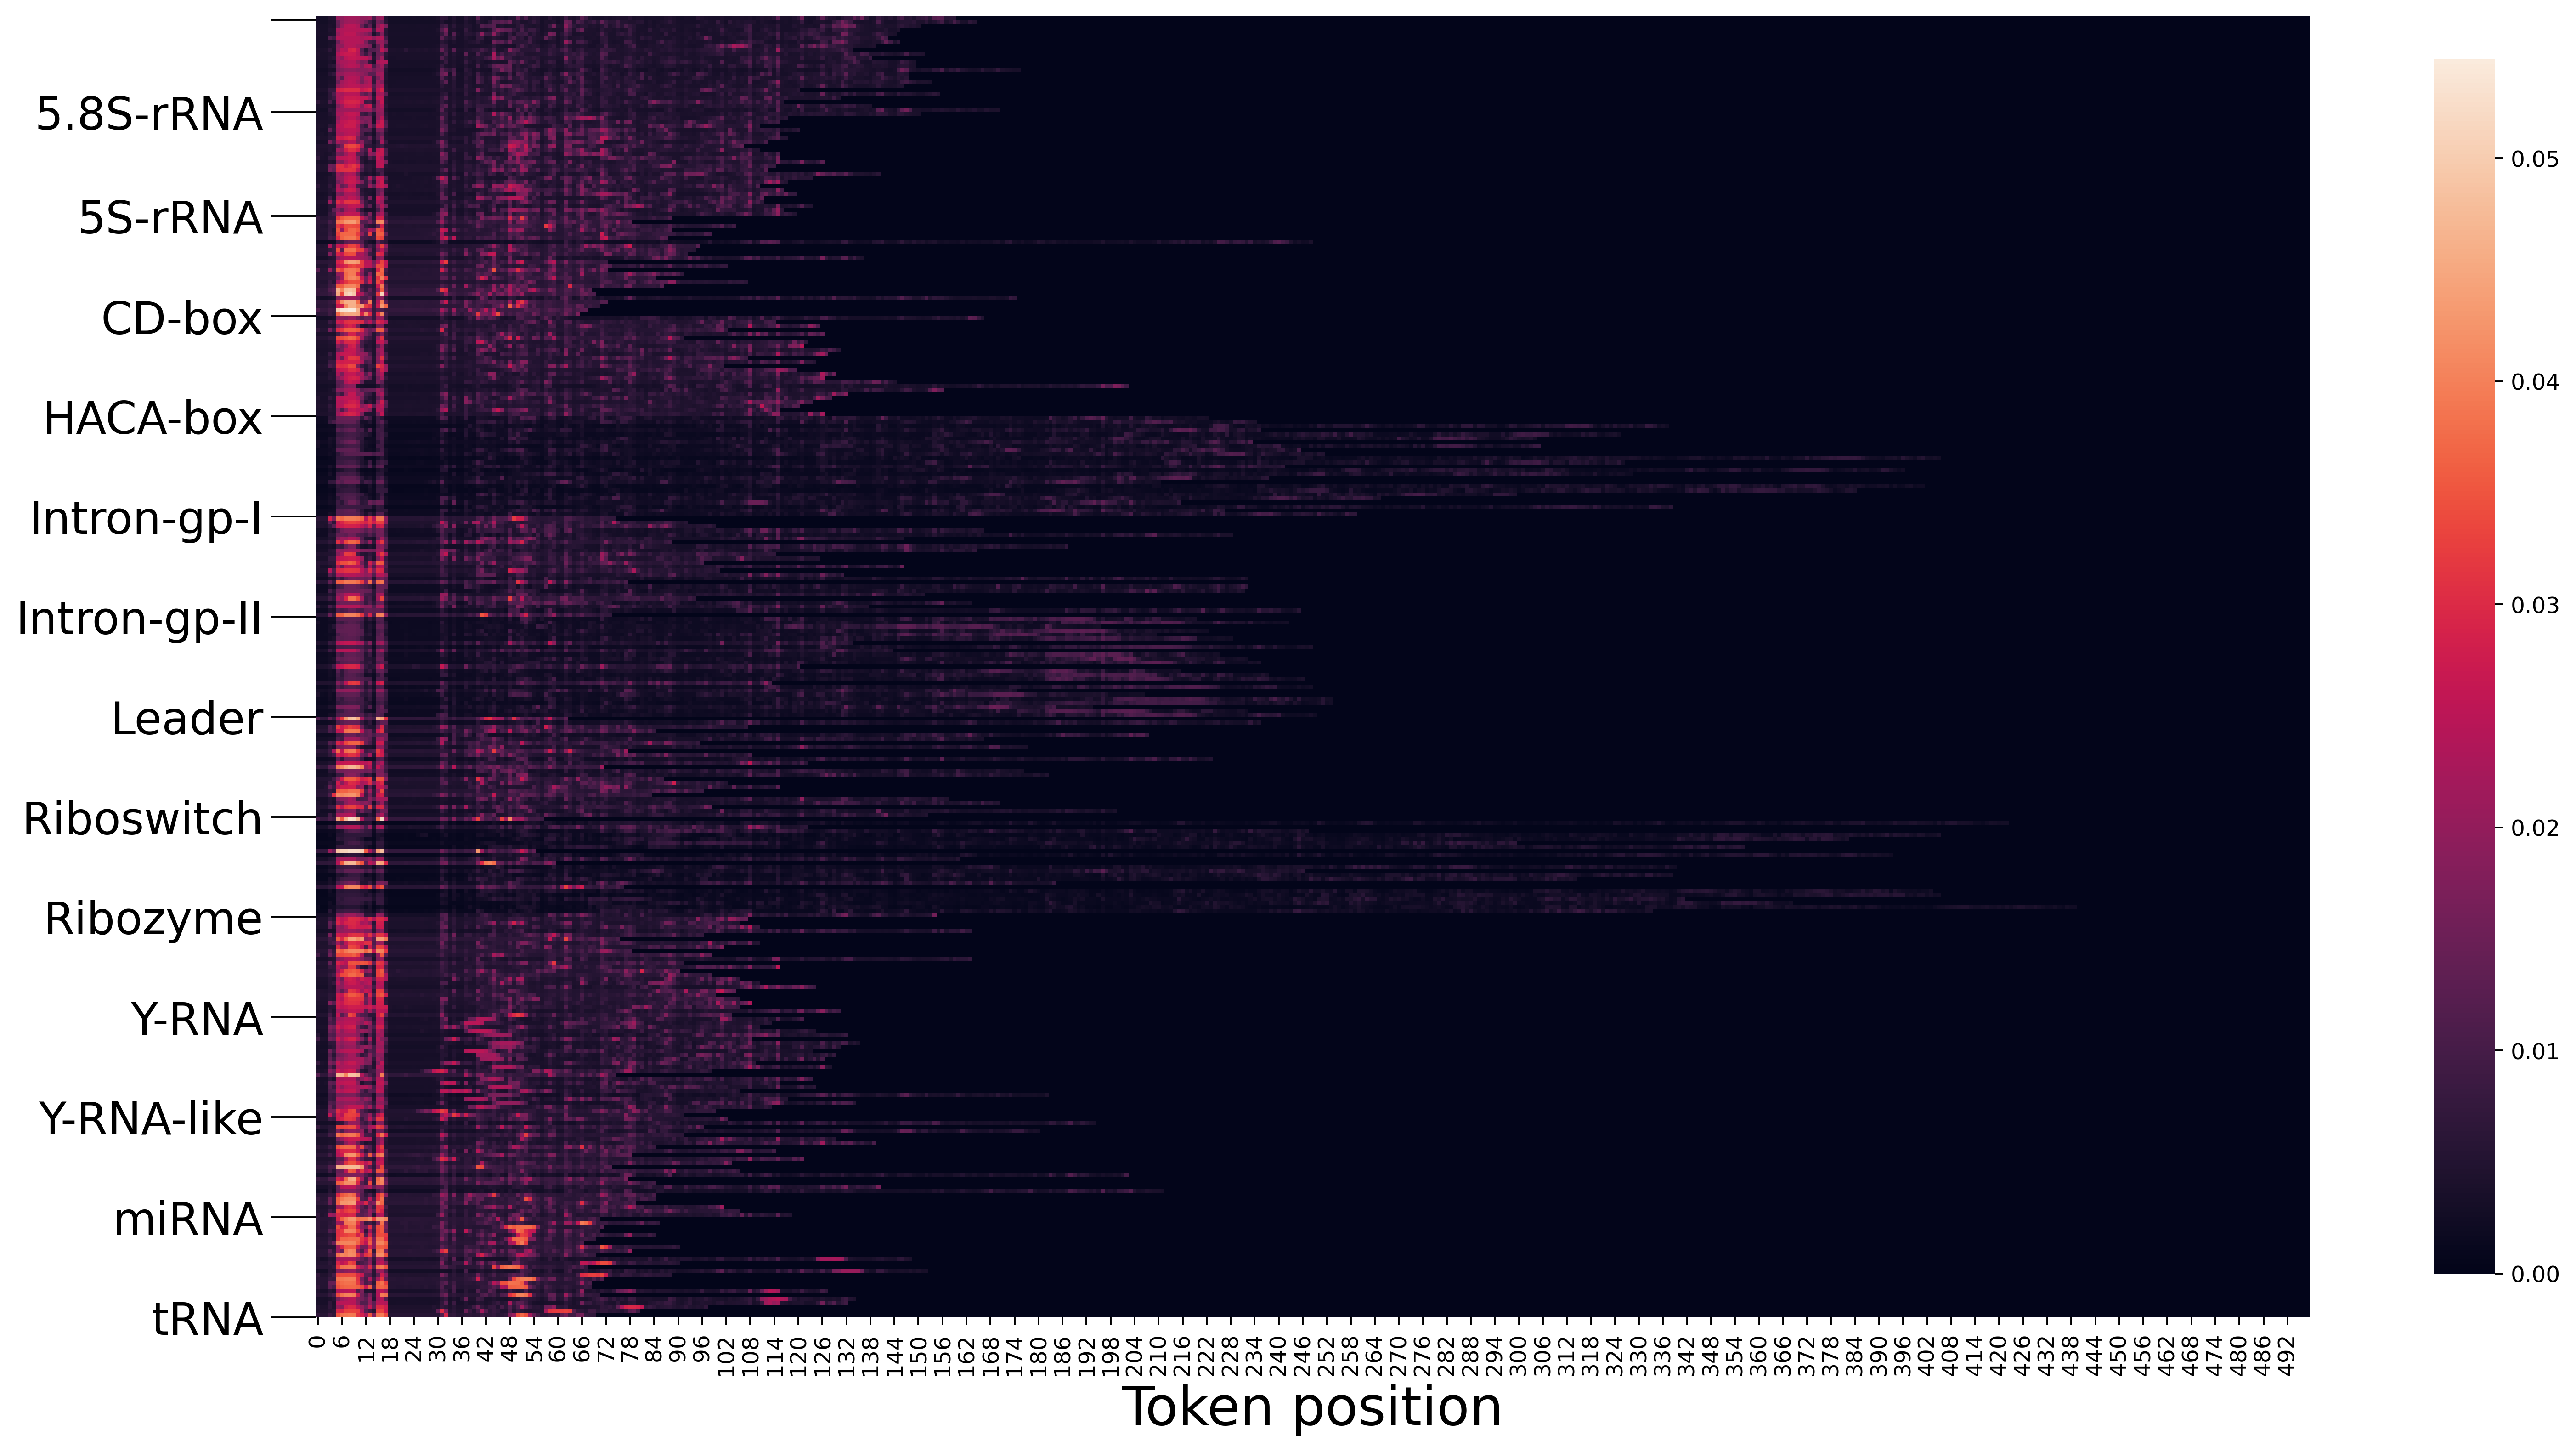

In [41]:
import seaborn as sns
fig = plt.figure(figsize=(20, 20), dpi=350)
#sns.heatmap(attention.iloc[:5,:200], square=True, cbar_kws={"shrink": .05})
#yticks = [1, 199, 399, 599, 799, 999, 1199, 1399, 1599, 1799, 1906, 1946, 2146, 2346]
yticks = [1, 24, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325 ]
#plt.xlabel('Token position', fontsize=24)

yticklabels = ['', '5.8S-rRNA', '5S-rRNA', 'CD-box', 'HACA-box', 'Intron-gp-I', 'Intron-gp-II',
                   'Leader', 'Riboswitch', 'Ribozyme', 'Y-RNA', 'Y-RNA-like', 'miRNA', 'tRNA'] 

#for i in yticks:
#    idx_pos = df_nrc['labels'][i]
#    yticklabels.append(idx_pos)
    
ax1 = sns.heatmap(attention, square=True, cbar_kws={"shrink": 0.5})
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels, fontsize=20)
ax1.tick_params(axis='y', length=20)
plt.xlabel('Token position', fontsize=24)
plt.show()